In [64]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def tokenize(text):
    # We get tokens with atleast one alphabet using 
    # this regular expression
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
        
    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []
    
    for i in range(N):
        indices = list(range(max(0, i - window_size), i)) + \
                    list(range(i+1, min(N, i + window_size + 1)))
        for j in indices:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
    
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
    
    return X, Y

In [66]:
# Initial document
doc = "After the deduction of the costs of investing, "\
        "beating the stock market is a loser's game."
# list of words in doc
tokens = tokenize(doc)
# word to id and id to word representation of each word and id
word_to_id, id_to_word = mapping(tokens)
# generation of all pairs of (x, y) where x is the id of a word in doc
# and y is the id of a word within specified window size in the doc
X, Y = generate_training_data(tokens, word_to_id, window_size=3)
# size of the vocabulary
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [67]:
X

array([[ 5,  5,  5, 12, 12, 12, 12,  7,  7,  7,  7,  7,  2,  2,  2,  2,
         2,  2, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  2,  2,
         2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  8,  8,  8,  8,  8,  8,
        12, 12, 12, 12, 12, 12,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,
         6,  6, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,  4, 10, 10, 10,
        10,  9,  9,  9]])

In [68]:
# Procedure: 
# 1) Initialize weights
# 2) Forward prop
# 3) Calculation of cost function
# 4) Backprop
# 5) Update weights
# Repeat

In [69]:
# Initialization of parameters to train
# 1) Word embedding layer 
# 2) Dense softmax layer
# Shape of word embedding layer will be (vocab_size, emb_size)
# Each row represents a word in one embedding of size emb_size
# Shape of dense layer is (vocab_size, emb_size)
# I/P to dense layer : (emb_size, #training_instances)
# O/P of dense layer: (vocab_size, #training_instances)
def initialize_word_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus training data
    emb_size: int. word embedding size. How many dimensions the vocab is represented in
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size)*0.01
    
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: size of input in dense layer
    output_size: size of output in dense layer
    """
    W = np.random.randn(output_size, input_size)
    
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    Initialize all training parameters
    """
    WRD_EMB = initialize_word_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

In [70]:
# Code for forward propagation

def ind_to_word_vecs(indices, parameters):
    """
    indices: numpy array of ids of words (1, m)
    parameters: dict. weights to be trained
    
    word_vec: We pick out all rows of WRD_EMB corresponding to 
    array indices and transpose the matrix. In resulting matrix, 
    each column corresponds to a word embedding of emb_size. 
    Matrix size is (emb_size, m)
    """
    m = indices.shape[1]
    WRD_EMB = parameters["WRD_EMB"]
    word_vec = WRD_EMB[indices.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array returned by ind_to_word_vecs. (emb_size, m)
    parameters: dict. weights to be trained
    """
    
    W = parameters['W']
    m = word_vec.shape[1]
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return Z

def softmax(Z):
    """
    Z - output of the dense layer, shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis= 0, keepdims = True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)
    
    return softmax_out

def forward_propagation(indices, parameters):
    word_vec = ind_to_word_vecs(indices, parameters)
    W, Z = parameters['W'], linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['W'] = W
    caches['Z'] = Z
    caches['word_vec'] = word_vec
    caches['indices'] = indices
    
    return softmax_out, caches

In [71]:
# Computation of Cross-entropy cost
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output of softmax
    Y: actual labels
    """
    m = softmax_out.shape[1]
    cost = (-1/m)*np.sum(np.sum(Y*np.log(softmax_out+0.001), axis=0, keepdims=True), axis=1)
    return cost

In [72]:
# Code for backward propagation
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. result from each step of forward prop
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1/m)*np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    indices = caches['indices']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = indices.shape[-1]
    
    WRD_EMB[indices.flatten(), :] -= dL_dword_vec.T * learning_rate
    parameters['W'] -= learning_rate*gradients['dL_dW']

In [73]:
# Code for training the model
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, \
                           epochs, batch_size=256, parameters=None, \
                           print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encoding of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of corpus or training data
    emb_size: word embedding size. How many dimensions to represent 
              each vocabulary
    learning_rate: alpha in the weights update formula after backprop
    epochs: how many epochs to train out model
    batch_size: size of mini-batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print cost during training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_indices = list(range(0, m, batch_size))
        np.random.shuffle(batch_indices)
        for i in batch_indices:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]
            
            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (50) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (50) == 0:
            learning_rate *= 0.98
    
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.5489816728310304
Cost after epoch 50: 5.128191262648
Cost after epoch 100: 5.243063468087623
Cost after epoch 150: 5.2534251318968455
Cost after epoch 200: 5.218283881677052
Cost after epoch 250: 5.143409026200252
Cost after epoch 300: 5.020222183523817
Cost after epoch 350: 4.838006785417612
Cost after epoch 400: 4.6290830882634895
Cost after epoch 450: 4.461360361379669
Cost after epoch 500: 4.301220781284504
Cost after epoch 550: 4.119348527030824
Cost after epoch 600: 3.936220220058227
Cost after epoch 650: 3.8001224689003994
Cost after epoch 700: 3.689147511116835
Cost after epoch 750: 3.5785342783155047
Cost after epoch 800: 3.4709826297970023
Cost after epoch 850: 3.3803795536418604
Cost after epoch 900: 3.309240883815884
Cost after epoch 950: 3.2480023473737147
Cost after epoch 1000: 3.191897455905921
Cost after epoch 1050: 3.1397138084014458
Cost after epoch 1100: 3.0914598363087156
Cost after epoch 1150: 3.0480989945036243
Cost after epoch 1200: 3.009773

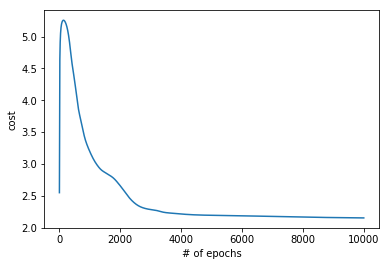

In [75]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 10000, batch_size=128, parameters=None, print_cost=True)

In [95]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_indices = np.argsort(softmax_test, axis=0)[-4:, :]
top_sorted_indices

array([[ 5,  4,  8, 12, 10,  0,  8,  8,  0,  8, 10, 10,  8],
       [ 1,  8,  0,  6,  3,  7,  4, 12,  3,  4,  3,  3, 12],
       [ 2,  3,  2, 11,  6, 12, 11,  5, 12, 11,  6,  6,  2],
       [ 8, 12, 12,  4,  9,  2, 10,  0,  6, 10,  9,  9, 11]])

In [97]:
for input_index in range(vocab_size):
    output_word_indices = top_sorted_indices[::-1, input_index]
    input_word = id_to_word[input_index]
    output_words = [id_to_word[output_index] for output_index in \
                    output_word_indices]
    print("{}'s neighbor words: {}".format(input_word, output_words))

costs's neighbor words: ['beating', 'of', 'investing', 'after']
investing's neighbor words: ['the', 'stock', 'beating', 'a']
of's neighbor words: ['the', 'of', 'costs', 'beating']
stock's neighbor words: ['a', 'is', 'market', 'the']
a's neighbor words: ['game', 'market', 'stock', "loser's"]
after's neighbor words: ['of', 'the', 'deduction', 'costs']
market's neighbor words: ["loser's", 'is', 'a', 'beating']
deduction's neighbor words: ['costs', 'after', 'the', 'beating']
beating's neighbor words: ['market', 'the', 'stock', 'costs']
game's neighbor words: ["loser's", 'is', 'a', 'beating']
loser's's neighbor words: ['game', 'market', 'stock', "loser's"]
is's neighbor words: ['game', 'market', 'stock', "loser's"]
the's neighbor words: ['is', 'of', 'the', 'beating']
